# Load DeepFly3D Data

In [2]:
%load_ext autoreload
%autoreload 2
from load import *
import torch
import yaml
import logging
from imp import reload
import matplotlib.pyplot as plt
from liftpose.vision_3d import world_to_camera_dict, reprojection_error, intrinsic_matrix, project_to_random_eangle, process_dict
reload(logging)
logger = logging.getLogger(__name__).setLevel(logging.INFO)
from tqdm import tqdm
tqdm.get_lock().locks = []

# declare data parameters
par_train = {  'data_dir'       : '/data/LiftPose3D/fly_tether/data_DF3D', #mac/ubuntu path format
              #'data_dir'       : r'\Users\NeLy\Desktop\fly_tether', #windows path format
               'out_dir'        : '/data/LiftPose3D/fly_tether/angle_inv_network_errors',
               'train_subjects' : [1,2,3,4,5,6],
               'test_subjects'  : [7,8],
               'actions'        : ['all'],
               'cam_id'         : [0,1]}

#angle augmentation parameters (use 180 deg coverage for both side cameras)
training_kwargs = {'eangles':  {0: [[-225,-45], [-2, 2], [-2,2]], 1: [[-45,135], [-2, 2], [-2,2]]},
                   'axsorder': 'yxz',
                   'vis': None,
                   'tvec': None,
                   'intr': None}

# merge with training parameters
par_data = yaml.full_load(open('param.yaml', "rb"))
par = {**par_data["data"], **par_train}

# Load 3D data
train_3d, train_keypts, rcams_train = load_3D(
    par["data_dir"],
    par,
    cam_id=par["cam_id"],
    subjects=par["train_subjects"],
    actions=par["actions"],
)

#generate test data by random projections
test_3d_0, test_keypts_0, _ = load_3D(
    par["data_dir"],
    par,
    cam_id=[0],
    subjects=par["test_subjects"],
    actions=par["actions"],
)
test_2d_0, angles_0 = process_dict(
            project_to_random_eangle,
            test_3d_0,
            2,
            [[-225,-45], [-2, 2], [-2,2]],
            axsorder=training_kwargs['axsorder'],
            project=True,
            tvec = training_kwargs['tvec'],
            intr = training_kwargs['intr'],
        )

test_3d_1, test_keypts_1, _ = load_3D(
    par["data_dir"],
    par,
    cam_id=[1],
    subjects=par["test_subjects"],
    actions=par["actions"],
)
test_2d_1, angles_1 = process_dict(
            project_to_random_eangle,
            test_3d_1,
            2,
            [[-45,135], [-2, 2], [-2,2]],
            axsorder=training_kwargs['axsorder'],
            project=True,
            tvec = training_kwargs['tvec'],
            intr = training_kwargs['intr'],
        )

#merging dictionaries
test_3d = {**test_3d_0, **test_3d_1}
test_2d = {**test_2d_0, **test_2d_1}
test_keypts = {**test_keypts_0, **test_keypts_1}
angles = {**angles_0, **angles_1}

angles = np.vstack(list(angles.values()))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Train LiftPose3D Network on DeepFly3D Data

In [3]:
from liftpose.preprocess import obtain_projected_stats

stats = obtain_projected_stats(train_3d, 
                              training_kwargs['eangles'], 
                              training_kwargs['axsorder'],
                              training_kwargs['vis'],
                              training_kwargs['tvec'],
                              training_kwargs['intr'], 
                              par['roots'], 
                              par['target_sets'],
                              par['out_dir'], 
                              load_existing=False,
                              th=1)

[preprocess.py:444]:INFO:Bootstrapping mean and variance...


/home/gosztolai/Dropbox/github/LiftPose3D/liftpose/preprocess.py:148: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(cp_d, axis=0)
/home/gosztolai/anaconda3/envs/LiftPose3D/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[preprocess.py:531]:INFO:Expected error for obtaining projection stats: 11.384574308836136
[preprocess.py:531]:INFO:Expected error for obtaining projection stats: 0.0030385720707594


In [4]:
from liftpose.main import train as lp3d_train
from liftpose.lifter.augmentation import random_project
aug = random_project(**training_kwargs)

lp3d_train(train_2d=None, test_2d=test_2d,
           train_3d=train_3d, test_3d=test_3d, 
           train_keypts=train_keypts,
           test_keypts=test_keypts,
           roots=par['roots'],
           target_sets=par['target_sets'],
           out_dir=par['out_dir'],
           training_kwargs={"epochs":10},
           augmentation=[aug],
           stats=stats)

/home/gosztolai/Dropbox/github/LiftPose3D/liftpose/preprocess.py:198: RuntimeWarning: invalid value encountered in true_divide
  tmp /= np.linalg.norm(tmp, ord='fro', axis=(1,2), keepdims=True)


[main.py:250]:INFO:Saving pre-processed 2D data at /data/LiftPose3D/fly_tether/angle_inv_network_errors/stat_2d.pth.tar.
[main.py:269]:INFO:Saving pre-processed 3D data at /data/LiftPose3D/fly_tether/angle_inv_network_errors/stat_3d.pth.tar.
[main.py:297]:INFO:Starting training model.
[main.py:307]:DEBUG:
==================Options=================
[main.py:308]:DEBUG:{   'batch_size': 64,
    'data_dir': '/data/LiftPose3D/fly_tether/angle_inv_network_errors',
    'dropout': 0.5,
    'epochs': 10,
    'exp': '',
    'is_train': True,
    'job': 8,
    'linear_size': 1024,
    'load': None,
    'lr': 0.001,
    'lr_decay': 5000,
    'lr_gamma': 0.9,
    'max_norm': True,
    'noise': None,
    'num_stage': 2,
    'out': '/data/LiftPose3D/fly_tether/angle_inv_network_errors',
    'out_dir': '/data/LiftPose3D/fly_tether/angle_inv_network_errors',
    'predict': False,
    'procrustes': False,
    'resume': False,
    'test': False}
[main.py:309]:DEBUG:======================================

Epoch 000 | LR  0.00081 | Loss Test  0.00000 | Loss Train  0.15482|: 100%|██████████| 11335/11335 [01:22<00:00, 136.91it/s]
Epoch 001 | LR  0.00066 | Loss Test  0.05752 | Loss Train  0.08681|: 100%|██████████| 11335/11335 [01:22<00:00, 136.62it/s]
Epoch 002 | LR  0.00053 | Loss Test  0.05091 | Loss Train  0.07972|: 100%|██████████| 11335/11335 [01:23<00:00, 135.08it/s]
Epoch 003 | LR  0.00039 | Loss Test  0.04622 | Loss Train  0.07583|: 100%|██████████| 11335/11335 [01:23<00:00, 135.45it/s]
Epoch 004 | LR  0.00031 | Loss Test  0.04296 | Loss Train  0.07338|: 100%|██████████| 11335/11335 [01:23<00:00, 135.51it/s]
Epoch 005 | LR  0.00025 | Loss Test  0.04260 | Loss Train  0.07161|: 100%|██████████| 11335/11335 [01:24<00:00, 133.96it/s]
Epoch 006 | LR  0.00021 | Loss Test  0.04130 | Loss Train  0.07025|: 100%|██████████| 11335/11335 [01:25<00:00, 132.39it/s]
Epoch 007 | LR  0.00015 | Loss Test  0.03980 | Loss Train  0.06921|: 100%|██████████| 11335/11335 [01:25<00:00, 133.25it/s]
Epoch 00

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


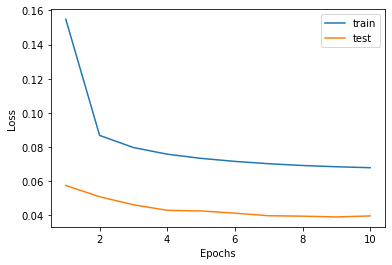

In [5]:
%matplotlib inline
from liftpose.plot import read_log_train, plot_log_train
epoch, lr, loss_train, loss_test, err_test = read_log_train(par['out_dir'])
plot_log_train(plt.gca(), loss_train, loss_test, epoch)

# Run Trained LiftPose3D Network on the Test Data

In [6]:
from liftpose.main import test as lp3d_test
lp3d_test(par['out_dir'])

[main.py:397]:INFO:starting testing in path: /data/LiftPose3D/fly_tether/angle_inv_network_errors
[lift.py:31]:INFO:Training on the device: cuda:0
[lift.py:53]:INFO:total params: 4.27M
[lift.py:61]:INFO:loading ckpt from '/data/LiftPose3D/fly_tether/angle_inv_network_errors/ckpt_best.pth.tar'
[lift.py:69]:INFO:ckpt loaded (epoch: 9 | err: 0.062346338510101094)
[lift.py:103]:INFO:Saving results: /data/LiftPose3D/fly_tether/angle_inv_network_errors/test_results.pth.tar


# Plot errors

In [11]:
from liftpose.postprocess import load_test_results
data = torch.load(os.path.join(par['out_dir'], "test_results.pth.tar"))
stat_2d, stat_3d = (
    torch.load(os.path.join(par['out_dir'], "stat_2d.pth.tar")),
    torch.load(os.path.join(par['out_dir'], "stat_3d.pth.tar")),
)
test_3d_gt, test_3d_pred, good_keypts = load_test_results(data, stat_2d, stat_3d)
error = np.abs(test_3d_gt - test_3d_pred).mean(2).mean(1)

Error around the circle

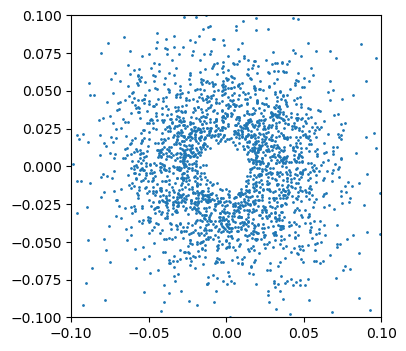

In [14]:
fig = plt.figure(figsize=plt.figaspect(1), dpi=100)
ax = fig.add_subplot(111)
x = error*np.cos(np.radians(angles[:,0]))
y = error*np.sin(np.radians(angles[:,0]))
ax.scatter(x[::100], y[::100], s=1)
ax.set_xlim([-0.1,0.1])
ax.set_ylim([-0.1,0.1])
plt.savefig('angle_error.svg')

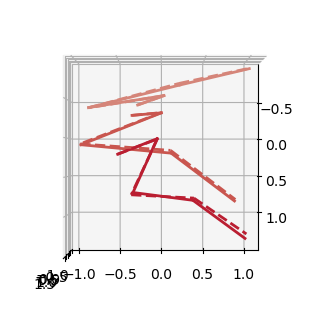

In [15]:
# https://stackoverflow.com/a/38865534/7554774
# conda install ipympl
#%matplotlib widget
%matplotlib inline
from liftpose.plot import plot_pose_3d

fig = plt.figure(figsize=plt.figaspect(1), dpi=100)
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=90, azim=0)

t = 100
plot_pose_3d(ax=ax, tar=test_3d_gt[t], 
            pred=test_3d_pred[t], 
            bones=par_data["vis"]["bones"], 
            limb_id=par_data["vis"]["limb_id"], 
            colors=par_data["vis"]["colors"],
            good_keypts=good_keypts[t],
            show_gt_always=False)